In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 10: Clustering Analysis in Python
Nov 7, 2019

## Housekeeping

- Assignment #6 due next week
- Last HW + final project description due in 3 weeks (Nov 26)

## Recap

- Last week: urban street networks + interactive web maps
- New tools: OSMnx, Pandana, and Folium
- Solutions to in-class exercises have been posted

## Today: Clustering

- Both spatial and non-spatial datasets
- Two new techniques: 
    - Non-spatial: **K-means**
    - Spatial: **DBSCAN**
- Two labs/exercises today:
    1. Grouping Philadelphia neighborhoods by AirBnb listings
    1. Identifying clusters in taxi rides in NYC

## Machine learning

<img src="imgs/machine_learning.jpg" width=700>

- The computer **learns** patterns and properties of an input data set without the user specifying them beforehand
- Can be both **supervised** and **unsupervised**

#### Supervised
- Example: classification
- Given a training set of **labeled** data, learn to assign labels to new data

#### Unsupervised
- Example: clustering
- Identify structure / clusters in data without any prior knowledge

## Machine learning in Python: scikit-learn

- State-of-the-art machine learning in Python
- Easy to use, lots of functionality

## Clustering is just one (of many) features
<img src="imgs/scikit_learn.png" width=700>

https://scikit-learn.org/stable/
    
**Note:** We will focus on clustering algorithms today and discuss a few other machine learning techniques in the next two weeks. If there is a specific scikit-learn use case we won't cover, I'm open to ideas for incorporating it as part of the final project. 

## Part 1: Non-spatial clustering

**The goal**

Partition a dataset into groups that have a similar set of attributes, **or features**, within the group and a dissimilar set of features between groups

## Some intuition
<img src="imgs/clustering.png" width=700>

## K-Means clustering

- Simple but robust clustering algorithm
- Widely used
- **Important:** user must specify the number of clusters
- **Cannot** be used to find density-based clusters

## This is just one of several clustering methods

https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods

## A good introduction

[Andrew Ng's Coursera lecture](https://www.youtube.com/watch?v=hDmNF9JG3lo&feature=youtu.be)

## How does it work?

**Minimizes the intra-cluster variance**: minimizes the sum of the squared distances between all points in a cluster and the cluster centroid

## K-means in action

<img src="imgs/K-means_convergence.gif" width=500>

## Example: clustering countries by health and income

- Health expectancy in years vs. GDP per capita and population for 187 countries (as of 2015)
- Data from [Gapminder](https://www.gapminder.org/data/)

In [3]:
import altair as alt
from vega_datasets import data
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

Read the data from a URL:

In [4]:
gapminder = pd.read_csv(data.gapminder_health_income.url)
gapminder.head()

country  income  health  population
0  Afghanistan    1925   57.63    32526562
1      Albania   10620   76.00     2896679
2      Algeria   13434   76.50    39666519
3      Andorra   46577   84.10       70473
4       Angola    7615   61.00    25021974

## Plot it with altair

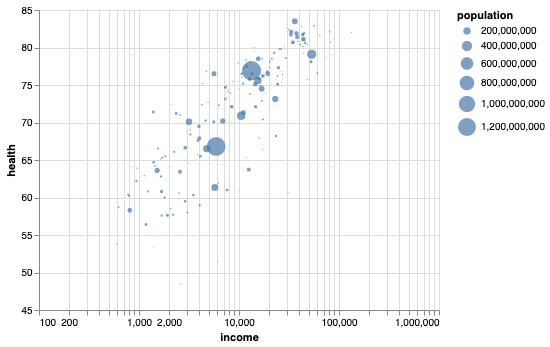

In [5]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    tooltip=list(gapminder.columns)
).interactive()

## K-Means with scikit-learn

In [6]:
from sklearn.cluster import KMeans

Let's start with 5 clusters

In [7]:
kmeans = KMeans(n_clusters=5)

Lot's of optional parameters, but `n_clusters` is the most important:

In [8]:
 kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Let's fit just income first

Use the `fit()` function

In [9]:
kmeans.fit(gapminder[['income']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Extract the cluster labels

Use the `labels_` attribute

In [10]:
gapminder['label'] = kmeans.labels_

## How big are our clusters?

In [11]:
gapminder.groupby('label').size()

label
0    106
1     24
2      6
3     50
4      1
dtype: int64

## Plot it again, coloring by our labels

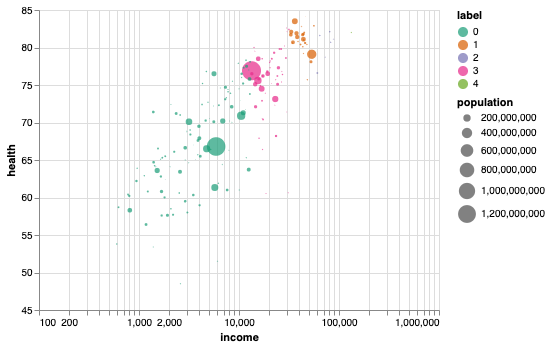

In [12]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

### Calculate average income by group

In [14]:
gapminder.groupby("label")['income'].mean().sort_values()

label
0      5279.830189
3     21040.820000
1     42835.500000
2     74966.166667
4    132877.000000
Name: income, dtype: float64

Data is nicely partitioned into income levels

## How about health, income, and population?

In [15]:
# fit all three columns
kmeans.fit(gapminder[['income', 'health', 'population']])

# extract the labels
gapminder['label'] = kmeans.labels_

## Plot the new labels

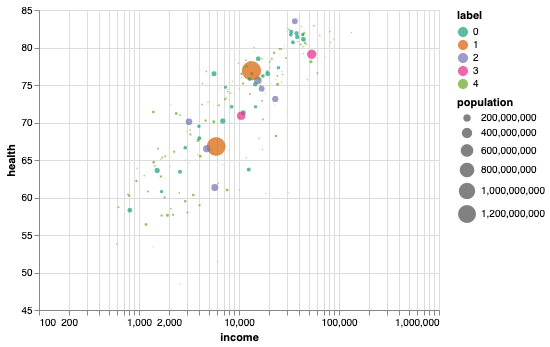

In [16]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

### It....didn't work that well

What's wrong?

**K-means is distance-based, but our features have wildly different distance scales**

## scikit-learn to the rescue: pre-processing

* Scikit-learn has a utility to normalize features with an average of zero and a variance of 1
* Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

## Use the `fit_transform()` function to scale your features

In [20]:
gapminder_scaled = scaler.fit_transform(gapminder[['income', 'health', 'population']])

In [21]:
# mean of zero
gapminder_scaled.mean(axis=0)

array([ 8.07434927e-17, -1.70511258e-15, -1.89984689e-17])

In [22]:
# variance of one
gapminder_scaled.std(axis=0)

array([1., 1., 1.])

## Now fit the scaled features

In [23]:
# perform the fit
kmeans.fit(gapminder_scaled)

# extract the labels
gapminder['label'] = kmeans.labels_

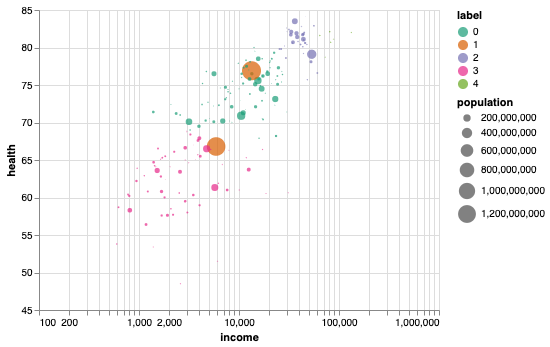

In [24]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

In [25]:
gapminder.loc[gapminder['label']==4]

country  income  health  population  label
24       Brunei   73003    78.7      423188      4
88       Kuwait   82633    80.7     3892115      4
97   Luxembourg   88314    81.1      567110      4
124      Norway   64304    81.6     5210967      4
134       Qatar  132877    82.0     2235355      4
145   Singapore   80794    82.1     5603740      4

In [26]:
# Number of countries per cluster
gapminder.groupby("label").size()

label
0    86
1     2
2    32
3    61
4     6
dtype: int64

In [27]:
# Average population per cluster
gapminder.groupby("label")['population'].mean().sort_values()

label
4    2.988746e+06
3    2.144130e+07
0    2.623994e+07
2    3.250103e+07
1    1.343550e+09
Name: population, dtype: float64

In [28]:
# Average life expectancy per cluster
gapminder.groupby("label")['health'].mean().sort_values()

label
3    62.232951
1    71.850000
0    74.313837
2    80.806250
4    81.033333
Name: health, dtype: float64

In [30]:
# Average income per cluster
gapminder.groupby("label")['income'].mean().sort_values()

label
3     4150.622951
1     9618.500000
0    13229.906977
2    40322.093750
4    86987.500000
Name: income, dtype: float64

## Exercise: clustering neighborhoods by Airbnb stats

I've extracted neighborhood Airbnb statistics for Philadelphia neighborhoods from [Tom Slee's website](http://tomslee.net/airbnb-data)

The data includes average price per person, overall satisfaction, and number of listings.

## Two good references for Airbnb data

- [Tom Slee's website](http://tomslee.net/airbnb-data)
- [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

## Step 1: load the data

In [31]:
airbnb = pd.read_csv("data/philly_airbnb_by_neighborhoods.csv")
airbnb.head()

neighborhood  price_per_person  overall_satisfaction    N
0  ALLEGHENY_WEST        120.791667              4.666667   23
1     BELLA_VISTA         87.407920              3.158333  204
2         BELMONT         69.425000              3.250000   11
3     BREWERYTOWN         71.788188              1.943182  142
4       BUSTLETON         55.833333              1.250000   19

## Step 2: perform the K-Means fit

- Use our three features: `price_per_person`, `overall_satisfaction`, `N`
- I used 5 clusters, but you are welcome to experiment with different values!
- Scaling the features is recommended, but if the scales aren't too different, so probably isn't necessary in this case

In [32]:
kmeans = KMeans(n_clusters=5)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(airbnb[['price_per_person', 'overall_satisfaction', 'N']])

In [33]:
kmeans.fit(scaled_data)
airbnb['label'] = kmeans.labels_

## Step 3: calculate average features per cluster

To gain some insight into our clusters, after calculating the K-Means labels:
- group by the `label` column
- calculate the `mean()` of each of our features
- calculate the number of neighborhoods per cluster

In [34]:
airbnb.groupby('label').size()

label
0    24
1    57
2    22
3     1
4     1
dtype: int64

In [35]:
airbnb.loc[airbnb['label'] == 4]

neighborhood  price_per_person  overall_satisfaction   N  label
78    SHARSWOOD        387.626984                   5.0  31      4

In [36]:
airbnb.loc[airbnb['label'] == 3]

neighborhood  price_per_person  overall_satisfaction     N  label
75  RITTENHOUSE        136.263996              3.000924  1499      3

In [37]:
airbnb.groupby('label').mean().sort_values(by='price_per_person')

price_per_person  overall_satisfaction            N
label                                                     
1             66.342966              3.208131    62.561404
2             79.448376              0.869737    38.181818
0            115.670340              2.990393   298.791667
3            136.263996              3.000924  1499.000000
4            387.626984              5.000000    31.000000

## Step 4: plot a choropleth, coloring neighborhoods by their cluster label

- Part 1: Load the Philadelphia neighborhoods available in the data directory:  
    - `./data/philly_neighborhoods.geojson`
- Part 2: Merge the Airbnb data (with labels) and the neighborhood polygons
- Part 3: Use geopandas to plot the neighborhoods
    - The `categorical=True` and `legend=True` keywords will be useful here

In [38]:
hoods = gpd.read_file("./data/philly_neighborhoods.geojson")
hoods.head()

Name                                           geometry
0          LAWNDALE  POLYGON ((-75.08616 40.05013, -75.08893 40.044...
1  ASTON_WOODBRIDGE  POLYGON ((-75.00860 40.05369, -75.00861 40.053...
2      CARROLL_PARK  POLYGON ((-75.22673 39.97720, -75.22022 39.974...
3     CHESTNUT_HILL  POLYGON ((-75.21278 40.08637, -75.21272 40.086...
4         BURNHOLME  POLYGON ((-75.08768 40.06861, -75.08758 40.068...

In [39]:
airbnb.head()

neighborhood  price_per_person  overall_satisfaction    N  label
0  ALLEGHENY_WEST        120.791667              4.666667   23      1
1     BELLA_VISTA         87.407920              3.158333  204      0
2         BELMONT         69.425000              3.250000   11      1
3     BREWERYTOWN         71.788188              1.943182  142      2
4       BUSTLETON         55.833333              1.250000   19      2

In [40]:
# do the merge
airbnb2 = hoods.merge(airbnb, left_on='Name', right_on='neighborhood', how='left')

# assign -1 to the neighborhoods without any listings
airbnb2['label'] = airbnb2['label'].fillna(-1)

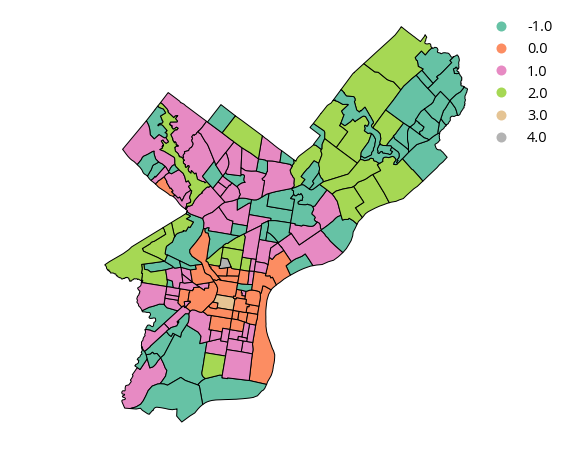

In [42]:
# plot the data
airbnb2 = airbnb2.to_crs(epsg=3857)

# setup the figure
f, ax = plt.subplots(figsize=(10,8))

# plot, coloring by label column
# specify categorical data and add legend
airbnb2.plot(column='label', cmap='Set2', categorical=True, legend=True, edgecolor='k', ax=ax)


ax.set_axis_off()
plt.axis('equal');

## Step 5: Plot an interactive map

Use altair to plot the clustering results with a tooltip for neighborhood name and tooltip.

**Hint:** See week 4's lecture on interactive choropleth's with altair

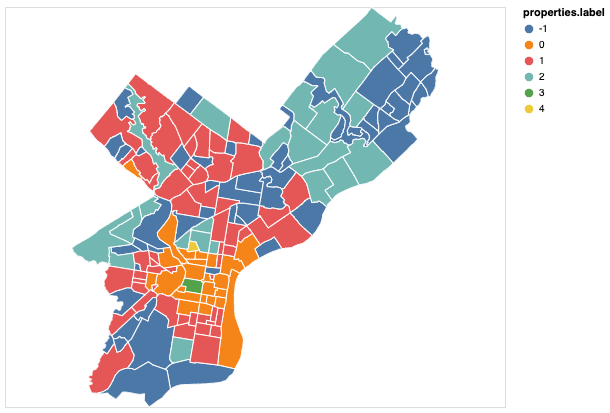

In [43]:
# create an altair data source from a GeoJSON representation
data  = alt.InlineData(values=airbnb2.to_crs(epsg=4326).to_json(),
                       format=alt.DataFormat(property='features',type='json'))

# plot map, where variables ares nested within `properties`, 
alt.Chart(data).mark_geoshape(
    stroke='white',
).properties(
    width=500,
    height=400,
    projection={"type":'mercator'},
).encode(
    tooltip=['properties.Name:N', 'properties.label:N'],
    color='properties.label:N'
)

## Based on these results, where would you want to stay?

Cluster #1 seems like the best bang for your buck!

## Part 2: Spatial clustering

Now on to the more traditional view of "clustering"...

## DBSCAN

"Density-Based Spatial Clustering of Applications with Noise"

- Clusters are areas of **high density** separated by areas of low density.
- Can identify clusters of any shape
- Good at separating **core samples** in high-density regions from low-density **noise** samples
- **Best for spatial data**

## Two key parameters 

1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
1. **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point.

## Importance of parameter choices

Higher `min_samples` or a lower `eps` requires a higher density necessary to form a cluster.

## Example: OpenStreetMap GPS traces in Philadelphia

Data extracted from the set of 1 billion GPS traces from OSM

In [44]:
coords = gpd.read_file('./data/osm_gps_philadelphia.geojson')
coords.head() 

x          y                          geometry
0 -8370750.5  4865303.0  POINT (-8370750.500 4865303.000)
1 -8368298.0  4859096.5  POINT (-8368298.000 4859096.500)
2 -8365991.0  4860380.0  POINT (-8365991.000 4860380.000)
3 -8372306.5  4868231.0  POINT (-8372306.500 4868231.000)
4 -8376768.5  4864341.0  POINT (-8376768.500 4864341.000)

In [45]:
len(coords)

52358

## DBSCAN basics

In [46]:
from sklearn.cluster import dbscan 

In [47]:
# some parameters to start with
eps = 50  # in meters
min_samples = 50

cores, labels = dbscan(coords[["x", "y"]], eps=eps, min_samples=min_samples)

The function returns two objects, which we call `cores` and `labels`. `cores` contains the indices of each point which is classified as a core. 

In [50]:
# the first 5 elements
cores[:5]

array([ 1,  4,  6, 10, 12])

The length of cores tells you how many samples were grouped into *any* cluster:

In [51]:
print(len(cores))

19370


The `labels` tells you the cluster number each sample belongs to. Those points classified as noise receive a cluster number of `-1`: 

In [52]:
# the first 5 elements
labels[:5]

array([-1,  0, -1, -1,  1])

The `labels` array is the same length as our input data, so we can add it as a column in our original data frame

In [54]:
# add our labels to the original data
coords['label'] = labels

The number of clusters is the number of unique labels minus one (because noise has a label of -1)

In [55]:
num_clusters = coords['label'].nunique() - 1
print("number of clusters = ", num_clusters)

number of clusters =  87


We can group by the `label` column to get the size of each cluster:

In [56]:
coords.groupby('label').size()

label
-1     29054
 0       113
 1      4073
 2      1787
 3      3370
       ...  
 82       54
 83       56
 84       50
 85       53
 86       50
Length: 88, dtype: int64

## Now let's plot the noise and clusters

- Extract each cluster: select points with the same label number
- Plot the cluster centers: the mean `x` and mean `y` value for each cluster

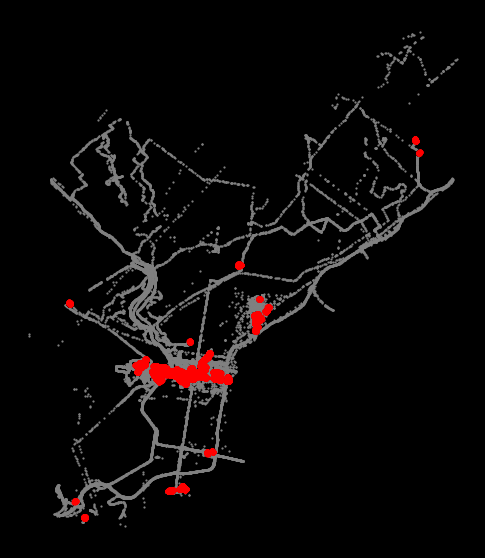

In [57]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(10, 10), facecolor='black')

# Plot the noise samples in grey
noise = coords.loc[coords['label']==-1]
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)

# loop over each cluster number
for label_num in range(num_clusters):
    
    # extract the samples with this label number
    this_cluster = coords.loc[coords['label'] == label_num]
    
    # plot the centroids
    ax.scatter(this_cluster['x'], this_cluster['y'], 
                linewidth=0, color='red')

# format and show
ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

## Extending DBSCAN beyond just spatial coordinates

DBSCAN can perform high-density clusters from more than just spatial coordinates, as long as they are properly normalized

## Exercise: Extracting patterns from NYC taxi rides

I've extracted data for taxi pickups or drop offs occurring in the Williamsburg neighborhood of NYC from the NYC taxi open data. 

Includes data for: 
- Pickup/dropoff location
- Fare amount
- Trip distance
- Pickup/dropoff hour

**Goal:** identify clusters of similar taxi rides that are not only clustered spatially, but also clustered for features like hour of day and trip distance

Inspired by [this CARTO blog post](https://carto.com/blog/using-location-data-identify-communities-williamsburg-ny/)

## Step 1: Load the data

In [58]:
taxi = pd.read_csv("./data/williamsburg_taxi_trips.csv")
taxi.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:05:41   2015-01-15 19:20:22                2           7.13   
1  2015-01-15 19:05:44   2015-01-15 19:17:44                1           2.92   
2  2015-01-25 00:13:06   2015-01-25 00:34:32                1           3.05   
3  2015-01-26 12:41:15   2015-01-26 12:59:22                1           8.10   
4  2015-01-20 22:49:11   2015-01-20 22:58:46                1           3.50   

    pickup_x   pickup_y  dropoff_x  dropoff_y  fare_amount  tip_amount  \
0 -8223667.0  4979065.0 -8232341.0  4970922.0         21.5        4.50   
1 -8237459.0  4971133.5 -8232725.0  4970482.5         12.5        2.70   
2 -8236711.5  4972170.5 -8232267.0  4970362.0         16.5        5.34   
3 -8222485.5  4978445.5 -8233442.5  4969903.5         24.5        5.05   
4 -8236294.5  4970916.5 -8231820.5  4971722.0         12.5        2.00   

   dropoff_hour  pickup_hour  
0            19           19  
1            19           19  
2             0            0  
3            12           12  
4            22           22

## Step 2: Extract and normalize several features

We will focus on the following columns:
- `pickup_x` and `pickup_y`
- `dropoff_x` and `dropoff_y`
- `trip_distance`
- `pickup_hour`

Use the `StandardScaler` to normalize these features.

In [59]:
feature_columns = [
    "pickup_x",
    "pickup_y",
    "dropoff_x",
    "dropoff_y",
    "trip_distance",
    "pickup_hour",
]
features = taxi[feature_columns].copy()

In [60]:
features

pickup_x   pickup_y  dropoff_x  dropoff_y  trip_distance  pickup_hour
0      -8223667.0  4979065.0 -8232341.0  4970922.0           7.13           19
1      -8237459.0  4971133.5 -8232725.0  4970482.5           2.92           19
2      -8236711.5  4972170.5 -8232267.0  4970362.0           3.05            0
3      -8222485.5  4978445.5 -8233442.5  4969903.5           8.10           12
4      -8236294.5  4970916.5 -8231820.5  4971722.0           3.50           22
...           ...        ...        ...        ...            ...          ...
223717 -8234402.0  4975683.0 -8231220.0  4971597.0           4.28           21
223718 -8238660.0  4970696.5 -8233435.0  4969915.0           3.60           17
223719 -8238718.5  4968866.5 -8233226.0  4970262.0           3.96           18
223720 -8236865.0  4970236.5 -8233068.0  4969843.5           2.40           18
223721 -8235721.0  4972331.0 -8234856.5  4971131.0           0.80           19

[223722 rows x 6 columns]

In [61]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features

array([[ 3.35254171e+00,  2.18196697e+00,  8.59345108e-02,
         1.89871932e-01, -2.58698769e-03,  8.16908067e-01],
       [-9.37728802e-01, -4.08167622e-01, -9.76176333e-02,
        -9.77141849e-03, -2.81690985e-03,  8.16908067e-01],
       [-7.05204353e-01, -6.95217705e-02,  1.21306539e-01,
        -6.45086739e-02, -2.80981012e-03, -1.32713022e+00],
       ...,
       [-1.32952083e+00, -1.14848599e+00, -3.37095821e-01,
        -1.09933782e-01, -2.76011198e-03,  7.04063946e-01],
       [-7.52953521e-01, -7.01094651e-01, -2.61571762e-01,
        -3.00037860e-01, -2.84530879e-03,  7.04063946e-01],
       [-3.97090015e-01, -1.71084059e-02, -1.11647543e+00,
         2.84810408e-01, -2.93269014e-03,  8.16908067e-01]])

In [62]:
print(scaled_features.shape)
print(features.shape)

(223722, 6)
(223722, 6)


## Step 3: Run DBSCAN to extract high-density clusters

- We want the highest density clusters, ideally no more than about 30-50 clusters.
- Run the DBSCAN and experiment with different values of `eps` and `min_samples`
    - I started with `eps` of 0.25 and `min_samples` of 50 

- Add the labels to the original data frame and calculate the number of clusters. It should be less than 50 or so. 
    
**Hint:** If the algorithm is taking a long time to run (more than a few minutes), the `eps` is probably too big!

In [63]:
# run DBSCAN 
cores, labels = dbscan(scaled_features, eps=0.25, min_samples=50)

# Add the labels back to the original (unscaled) dataset
features['label'] = labels

In [64]:
# extract the number of clusters 
num_clusters = features['label'].nunique() - 1
print(num_clusters)

27


## Step 4: Identify the 5 largest clusters

Group by the label, calculate and sort the sizes to find the label numbers of the top 5 largest clusters

In [65]:
N = features.groupby('label').size()
print(N)

label
-1     101292
 0       4481
 1      50673
 2      33277
 3      24360
 4        912
 5       2215
 6       2270
 7       1459
 8        254
 9        519
 10       183
 11       414
 12       224
 13       211
 14       116
 15        70
 16        85
 17       143
 18        76
 19        69
 20        86
 21        49
 22        51
 23        97
 24        52
 25        41
 26        43
dtype: int64


In [66]:
N

label
-1     101292
 0       4481
 1      50673
 2      33277
 3      24360
 4        912
 5       2215
 6       2270
 7       1459
 8        254
 9        519
 10       183
 11       414
 12       224
 13       211
 14       116
 15        70
 16        85
 17       143
 18        76
 19        69
 20        86
 21        49
 22        51
 23        97
 24        52
 25        41
 26        43
dtype: int64

In [67]:
# sort from largest to smallest
N = N.sort_values(ascending=False)

# extract labels (ignoring label -1 for noise)
top5 = list(N.iloc[1:6].index)
print(top5)

[1, 2, 3, 0, 6]


## Step 5: Get mean statistics for the top 5 largest clusters

To better identify trends in the top 5 clusters, calculate the mean trip distance and pickup_hour for each of the clusters.

In [68]:
# get the features for the top 5 labels
selection = features['label'].isin(top5)

# select top 5 and groupby by the label
grps = features.loc[selection].groupby('label')

# calculate average pickup hour and trip distance per cluster
avg_values = grps[['pickup_hour', 'trip_distance']].mean()

avg_values

pickup_hour  trip_distance
label                            
0        18.599643       7.508730
1        20.127405       4.025859
2         1.699943       3.915581
3         9.536905       1.175154
6         1.494714       2.620546

## Step 6a: Visualize the top 5 largest clusters

Now visualize the top 5 largest clusters:
- plot the dropoffs and pickups (same color) for the 5 largest clusters
- include the "noise" samples, shown in gray
      

**Hints:**
- For a given cluster, plot the dropoffs and pickups with the same color so we can visualize patterns in the taxi trips
- A good color scheme for a black background is given below

In [69]:
# a good color scheme for a black background
colors = ['aqua', 'lime', 'red', 'fuchsia', 'yellow']

In [70]:
top5

[1, 2, 3, 0, 6]

In [71]:
# EXAMPLE: enumerating a list
for i, label_num in enumerate(top5):
    print(f"i = {i}")
    print(f"label_num = {label_num}")

i = 0
label_num = 1
i = 1
label_num = 2
i = 2
label_num = 3
i = 3
label_num = 0
i = 4
label_num = 6


plotting cluster #1...
plotting cluster #2...
plotting cluster #3...
plotting cluster #0...
plotting cluster #6...


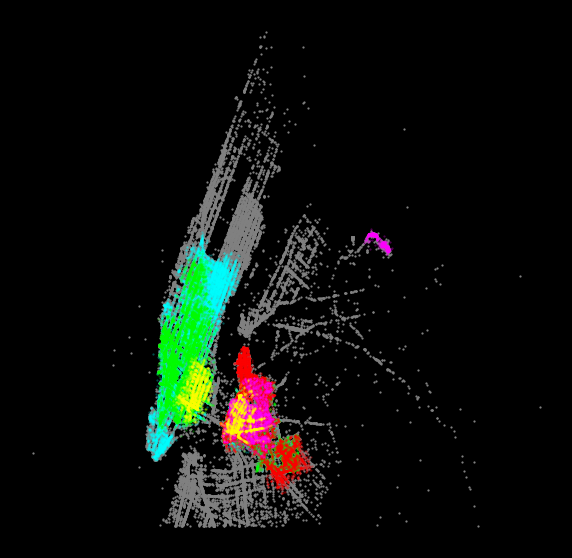

In [72]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(10, 10), facecolor='black')

# Plot noise in grey
noise = features.loc[features['label']==-1]
ax.scatter(noise['pickup_x'], noise['pickup_y'], c='grey', s=5, linewidth=0)

# specify colors for each of the top 5 clusters
colors = ['aqua', 'lime', 'red', 'fuchsia', 'yellow']

# loop over top 5 largest clusters
for i, label_num in enumerate(top5):
    print("plotting cluster #%d..." % label_num)
    
    # select all the samples with label equals "label_num"
    this_cluster = features.loc[features['label']==label_num]
    
    # plot pickups 
    ax.scatter(this_cluster['pickup_x'], this_cluster['pickup_y'], 
               linewidth=0, color=colors[i], s=5, alpha=0.3)
    
    # plot dropoffs
    ax.scatter(this_cluster['dropoff_x'], this_cluster['dropoff_y'], 
               linewidth=0, color=colors[i], s=5, alpha=0.3)
    
# Display the figure
ax.set_axis_off()
plt.show()

## Step 6b: Visualizing one cluster at a time

Another good way to visualize the results is to explore the other clusters one at a time, plotting both the pickups and dropoffs to identify the trends.  

Use different colors for pickups/dropoffs to easily identify them.

Make it a function so we can repeat it easily:

In [73]:
def plot_taxi_cluster(label_num):
    """
    Plot the pickups and dropoffs for the input cluster label
    """
    # Setup figure and axis
    f, ax = plt.subplots(1, figsize=(10, 10), facecolor='black')

    # Plot noise in grey
    noise = features.loc[features['label']==-1]
    ax.scatter(noise['pickup_x'], noise['pickup_y'], c='grey', s=5, linewidth=0)

    # get this cluster
    this_cluster = features.loc[features['label']==label_num]

    # plot pickups 
    ax.scatter(this_cluster['pickup_x'], this_cluster['pickup_y'], 
               linewidth=0, color='fuchsia', s=5, alpha=0.3)

    # plot dropoffs
    ax.scatter(this_cluster['dropoff_x'], this_cluster['dropoff_y'], 
               linewidth=0, color='aqua', s=5, alpha=0.3)

    # Display the figure
    ax.set_axis_off()
    plt.show()

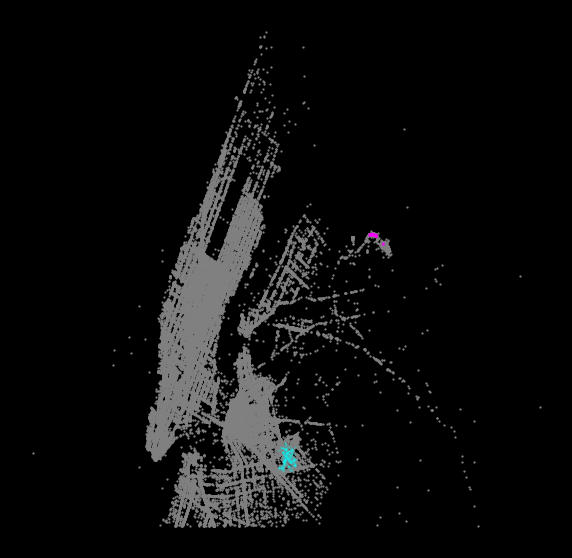

In [74]:
# plot specific label
plot_taxi_cluster(label_num=10)

## If you're feeling ambitious, and time-permitting...

## Step 7: an interactive map of clusters with hvplot + datashader

- We'll plot the pickup/dropoff locations for the top 5 clusters
- Use the `.hvplot.scatter()` function to plot the x/y points
- Specify the `c=` keyword as the column holding the cluster label
- Use the below `color_key` as the `cmap=` keyword
- Specify the aggregator as `ds.count_cat("label")` — this will color the data points using our categorical color map
- Use the `datashade=True` keyword to tell hvplot to use datashader
- Add a background tile using Geoviews
- Combine the pickups, dropoffs, and background tile into a single interactive map


In [85]:
# map colors to the top 5 cluster labels
color_key = dict(zip(top5, ['aqua', 'lime', 'red', 'fuchsia', 'yellow']))
print(color_key)

{1: 'aqua', 2: 'lime', 3: 'red', 0: 'fuchsia', 6: 'yellow'}


In [78]:
# extract the features for the top 5 clusters
top5_features = features.loc[features['label'].isin(top5)]


In [95]:
import hvplot.pandas
import datashader as ds
import geoviews as gv

In [94]:
# Pickups using a categorical color map
pickups = top5_features.hvplot.scatter(
    x="pickup_x",
    y="pickup_y",
    c="label",
    aggregator=ds.count_cat("label"),
    datashade=True,
    cmap=color_key,
    width=800,
    height=600,
)

# Dropoffs using a categorical color map
dropoffs = top5_features.hvplot.scatter(
    x="dropoff_x",
    y="dropoff_y",
    c="label",
    aggregator=ds.count_cat("label"),
    datashade=True,
    cmap=color_key,
    width=800,
    height=600,
)


pickups * dropoffs * gv.tile_sources.CartoDark

:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [pickup_x,pickup_y]   (R,G,B,A)
      .RGB.II :RGB   [dropoff_x,dropoff_y]   (R,G,B,A)
      .WMTS.I :WMTS   [Longitude,Latitude]